In [69]:
from pathlib import Path
from datetime import datetime, timedelta
from functools import reduce
from operator import add

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from music_league_graphs.scraper import create_dataframe
from music_league_graphs.spotify_api import SpotifyAPI

In [70]:
paths = [Path(f"../league_{i}") for i in range(1, 5)]

dfs: list[pd.DataFrame] = []
comment_dfs: list[pd.DataFrame] = []
names: set[str] = set()

for path in paths:
    df, comment_df, league_names = create_dataframe(path)
    df["league"] = path.stem
    dfs.append(df)
    comment_dfs.append(comment_df)
    names = names.union(set(league_names))

names = list(names)
df = pd.concat(dfs, axis=0, ignore_index=True)
comment_df = pd.concat(comment_dfs, axis=0, ignore_index=True)

In [71]:
df["round_score"] = df[names].sum(axis=1)
df["round_rank"] = df.groupby("round")["round_score"].rank(ascending=False).astype(int)


If you want to convert the music league user names to real names create a translator dictionary like the one below. Otherwise set translator to `None`, or just delete the block below

In [72]:

translator = {
    "Sacha Darwin": "Sacha",
    "Bethany Dickens-Devereux": "Bethany",
    "sam24ahhhhhh": "Sam",
    "Martha Mukungurutse": "Martha",
    "Victoria Whitehead": "Victoria",
    "Andrej Zacharenkov": "Andrej",
    "fred": "Fred",
    "Jenny": "Jenny B",
    "Tim            :)": "Tim P",
    "Mel Shallcrass": "Mel",
    "Jamie England": "Jamie",
    "Helen Adams": "Helen",
    "Rory": "Rory",
    "murraypurves101": "Murray",
    "James Hardwick": "James",
    "Olek": "Olek",
    "Russell": "Russell",
    "owainst": "Owain",
    "Tim": "Tim C",
    "Figataur": "Mark",
    "Jenny Seaborne": "Jenny S",
    "diplodocus.17": "Harry",
    "Sowdagar": "Sow",
    "[Left the league]": "[Left the league]",
    "Peter Rowe": "Peter R",
}

if translator is not None:
        df = df.replace(translator)
        df = df.rename(mapper=translator, axis=1)
        comment_df = comment_df.replace(translator)
        comment_df = comment_df.rename(mapper=translator, axis=1)
        names = list(set(translator.values()).intersection(set(df.keys())))

In [73]:
try:
    api = SpotifyAPI()
    api.get_data(df["song_id"])
    spotify_data = api.df
    df = pd.concat((df, spotify_data), axis=1)
except RuntimeError:
    print("Couldn't access spotify API")
    raise

/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Simply sorting the dataframe won't resolve ties correctly. The below one does

In [74]:
def resolve_podium(df) -> list[str]:
    """
    Resolve the winning order in case of draws in points. Resolution order is:
    1. Largest total positive votes
    2. Lowest number of down votes (not)
    """
    rankings = df.groupby("submitter")["round_score"].sum().rank(ascending=False).astype(int).sort_values()
    winning_order: list[str] = []

    rank = 1

    while rank != len(rankings) + 1:
        if len(rankings[rankings == rank]) > 1:
            tied_names = rankings[rankings == rank].index
            tie_break_df = df[df["submitter"].isin(tied_names)]
            tie_break_df.loc[:, names] = tie_break_df[names].map(lambda x: x if x > 0 else 0) # remove all downvotes
            positive_votes =  tie_break_df.groupby("submitter")[names].sum().sum(axis=1).sort_values()
            if len(set(positive_votes)) < len(positive_votes):
                print("Tie break unresolved, alphabetical order used")
            order = [k for k, _ in sorted(positive_votes.to_dict().items(), key=lambda item: item[1], reverse=True)]
            winning_order += order
            rank += len(order)
        else:
            winning_order.append((rankings[rankings==rank]).index[0])
            rank += 1
        if len(winning_order) == len(rankings):
            break
    return winning_order

winning_order = resolve_podium(df)


## Round Winners

Below we list all of the winners for each round

In [75]:
for round_name, scores in df.groupby("round"):
    winning_score = scores["round_score"].max()
    a = f"Round     | {round_name}"
    print(a + "\n" + '-'*len(a))
    for _, row in scores[scores["round_score"] == winning_score][["submitter", "song_name", "round_score"]].iterrows():
        print(f"{row['submitter']:10} | {row['song_name']:40} | {int(row['round_score'])}")
    print()


Round     | 120 seconds to go ⏱
-------------------------------
Mel        | Fell In Love With a Girl                 | 21

Round     | Advert songs 📺
--------------------------
Jenny S    | Venus                                    | 17

Round     | Back to basics 🎸
----------------------------
Rory       | Place To Be                              | 15

Round     | Best live version 🎤
-------------------------------
Jenny S    | The Man Who Sold The World - Live        | 24

Round     | Best sample 🎛
-------------------------
Jamie      | Stan                                     | 16

Round     | Best solo breakout from group 🚀
-------------------------------------------
Helen      | Edge of Seventeen                        | 18

Round     | Best summer song ☀
------------------------------
Martha     | Mas Que Nada                             | 20

Round     | Boxing entrance music 🥊
-----------------------------------
Martha     | X Gon' Give It To Ya                     | 20

Round 

### Highest and lowest scores across the league's rounds

In [76]:
# highest
df.sort_values("round_score", ascending=False).iloc[:10][["round", "submitter", "song_name", "round_score"]]

,round,submitter,song_name,round_score
168,Ich spreche kein Englisch 👽,murray,Mundian to Bach Ke,29.0
617,👇 Straight to the point,Tim C,Ready or Not,26.0
465,Sp00ky 👻,Fred,I Put A Spell On You,25.0
227,Best live version 🎤,Jenny S,The Man Who Sold The World - Live,24.0
113,Film Soundtrack 🎞,Jamie,Lose Yourself,23.0
38,Cover🎪,Jamie,Hurt,23.0
539,Breaking the law 🕵️‍♀️,Mel,Psycho Killer,22.0
57,120 seconds to go ⏱,Mel,Fell In Love With a Girl,21.0
114,Film Soundtrack 🎞,Martha,9 to 5,21.0
637,⚓ Track related to a Riskaware core value,Helen,Ice Ice Baby,20.0


In [77]:
# lowest
df.sort_values("round_score", ascending=True).iloc[:10][["round", "submitter", "song_name", "round_score"]]

,round,submitter,song_name,round_score
75,120 seconds to go ⏱,Andrej,Baby Shark,-17.0
130,Film Soundtrack 🎞,Olek,Waters of Nazareth x We Are your Friends x Pha...,-13.0
576,Colours 🎨,Sam,"Love Me Like You Do (From ""50 Shades of Grey"")...",-12.0
246,Best live version 🎤,Olek,Final - Live Version - Rappel,-12.0
350,Riskware's anthem 🎶,Fred,Funny Little Man,-11.0
267,To the polls❌,Sam,Do They Know It's Christmas? - 1984 Version,-11.0
56,Cover🎪,James,Bohemian Rhapsody,-11.0
616,🍎 Song with a fruit in the title,Sam,The Christmas Song (Chestnuts Roasting on an O...,-10.0
186,Ich spreche kein Englisch 👽,Andrej,Dragostea Din Tei,-10.0
774,🌡 Can you quantify that,Tim P,Butt Cheeks Butt Cheeks Butt Cheeks!,-10.0


## Voting Matrix

The voting matrix shows the cumlative votes given between every player across all of the rounds.

In [78]:
# arr has shape (num_rounds, num_competitors, num_competitors)
# Any missing values are filled with 0.0

arr: list[np.ndarray] = []
for _, a in df.set_index("submitter").groupby("round")[winning_order]:
    a = a.reindex(winning_order).fillna(0).to_numpy()
    arr.append(a[None, :, :])

arr = np.concat(arr)
voting_matrix = np.sum(arr, axis=0)

Rows are the points received, columns the points given. The rows and columns are sorted into the final order of the league

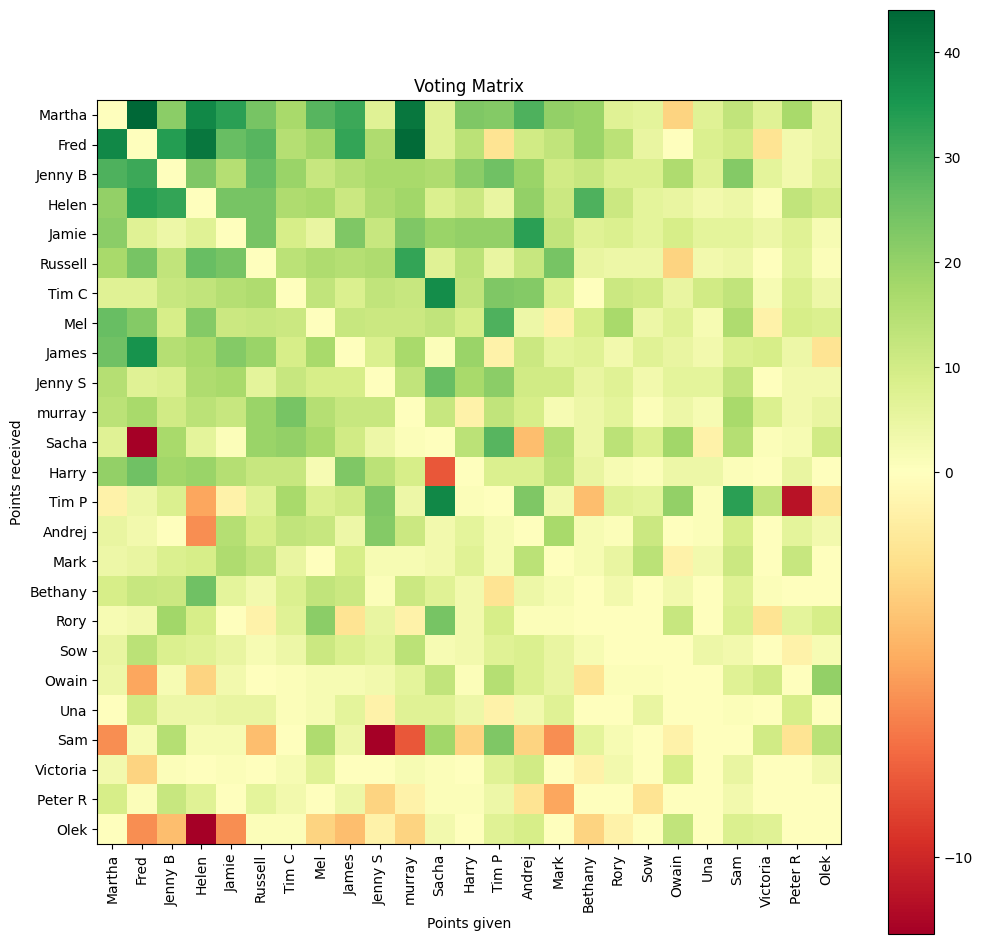

In [79]:
fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_matrix),
                        vcenter=0,
                        vmax=np.max(voting_matrix))

plt.imshow(voting_matrix, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.xlabel("Points given")
plt.ylabel("Points received")
plt.title("Voting Matrix")


cbar = plt.colorbar()

plt.show()

In [80]:
# Biggest differences 

reciprocals = np.abs((np.triu(voting_matrix) - np.tril(voting_matrix).T))
diffs = np.unravel_index(np.argsort(reciprocals.reshape(-1))[::-1][:10], reciprocals.shape)

for row, col in zip(*diffs):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

murray for Martha: 41
murray for Fred: 43
Andrej for Helen: 20
Sam for Jenny S: 13
Sam for murray: 17
Andrej for Martha: 29
Tim P for Martha: 22
Sacha for Jenny S: 26
Olek for Helen: 10
Harry for Sacha: 14


### Biggest Stans and biggest haters

In [81]:
biggest_haters = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[::-1][:10], voting_matrix.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Fred for Martha: 44
murray for Fred: 43
Helen for Fred: 41
murray for Martha: 41
Martha for Fred: 38
Sacha for Tim P: 38
Helen for Martha: 38
Sacha for Tim C: 37
Fred for James: 36
Jenny B for Fred: 34


In [82]:
biggest_haters = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[:10], voting_matrix.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Helen for Olek: -12
Jenny S for Sam: -12
Fred for Sacha: -12
Peter R for Tim P: -11
murray for Sam: -8
Sacha for Harry: -8
Martha for Sam: -6
Fred for Olek: -6
Helen for Andrej: -6
Mark for Sam: -6


## Voting Correlation

This shows who votes similarly, and who doesn't. Note that the matrix is symmetrical

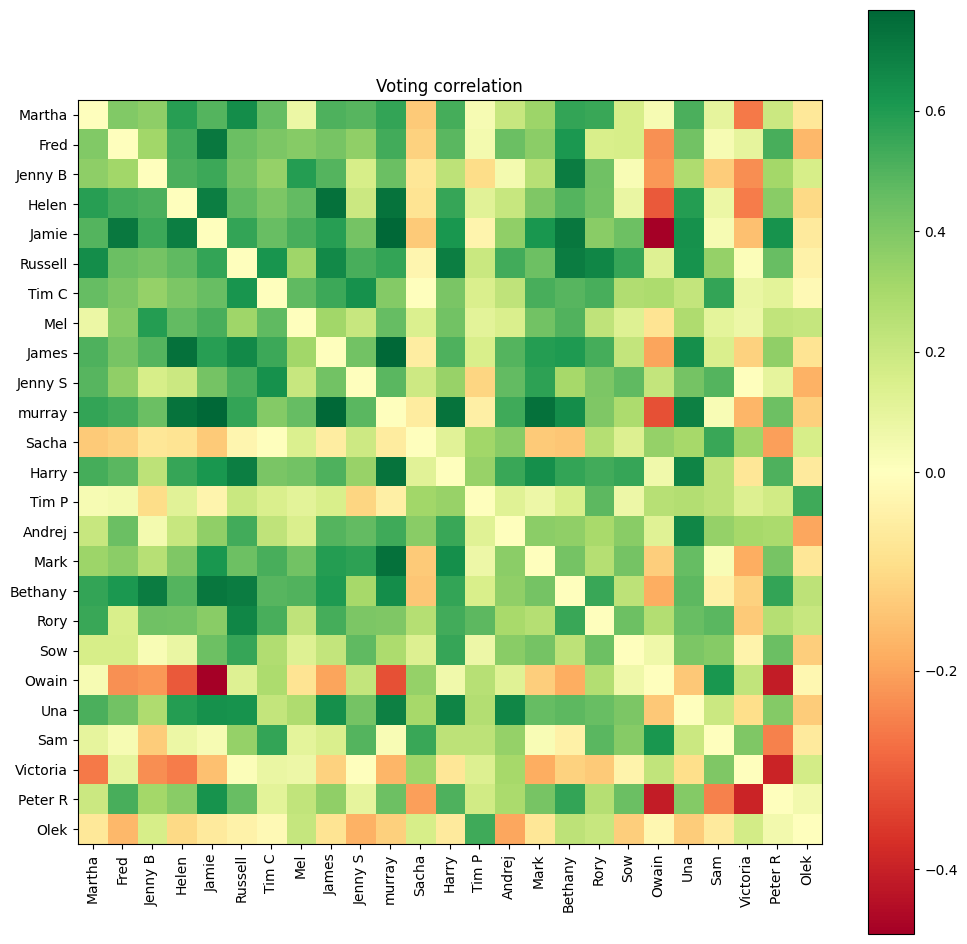

In [83]:
# Sort arr into an array that's lists of each competitors votes per round

voting_correlation = np.corrcoef(np.vstack(voting_matrix).T)
np.fill_diagonal(voting_correlation, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_correlation),
                        vcenter=0,
                        vmax=np.max(voting_correlation))

plt.imshow(voting_correlation, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.title("Voting correlation")


cbar = plt.colorbar()

plt.show()

### Most and least voting-correlated

In [84]:
most_correlated = np.unravel_index(np.argsort(-voting_correlation.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*most_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_correlation[row, col]:.2f}")

murray and James: 0.77
Jamie and murray: 0.76
Helen and James: 0.74
murray and Mark: 0.73
Harry and murray: 0.73
murray and Helen: 0.73
Bethany and Jamie: 0.71
Jamie and Fred: 0.71
Bethany and Jenny B: 0.70
Russell and Bethany: 0.70


In [85]:
least_correlated = np.unravel_index(np.argsort(voting_correlation.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*least_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_correlation[row, col]:.2f}")

Jamie and Owain: -0.46
Owain and Peter R: -0.41
Victoria and Peter R: -0.39
Owain and murray: -0.32
Helen and Owain: -0.31
Martha and Victoria: -0.26
Victoria and Helen: -0.25
Peter R and Sam: -0.25
Jenny B and Victoria: -0.23
Fred and Owain: -0.23


## Genre Correlation

See who submitted similar genres. Note that Spotify's list of genres is pretty wild, so this is pretty rough

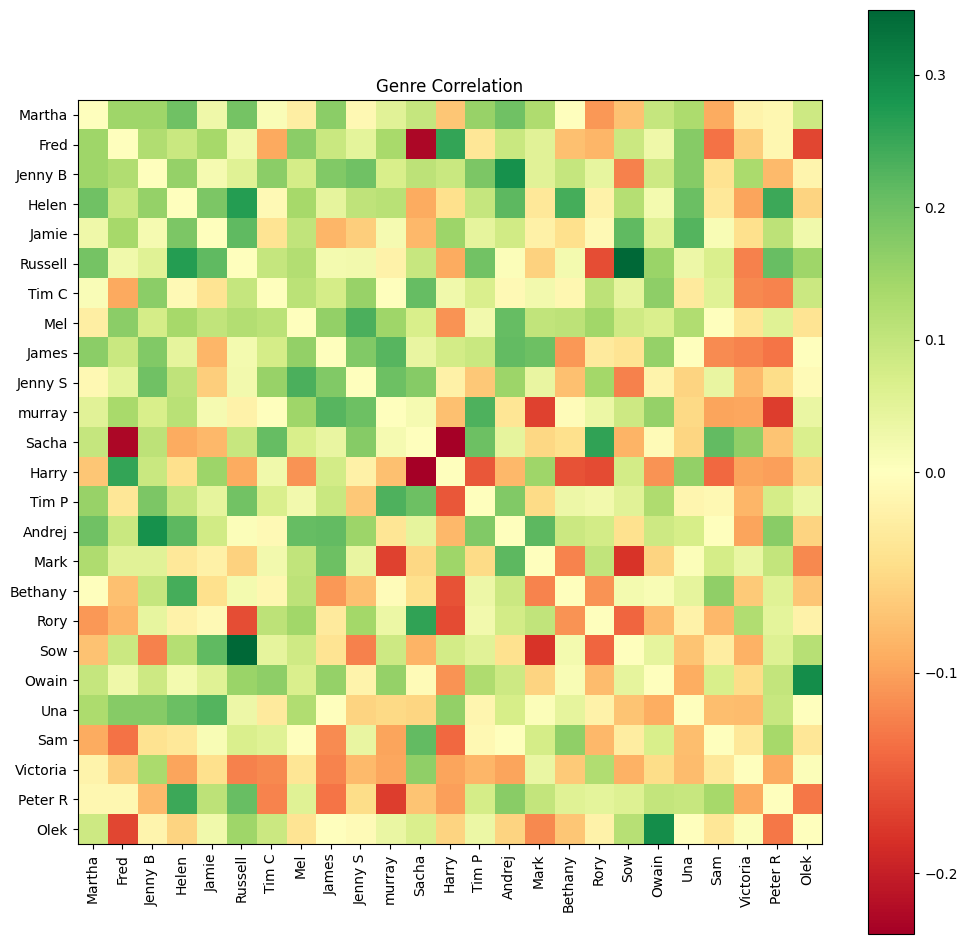

In [86]:
unique_genres = set()

for submitter in winning_order:
    rest = set(reduce(add, df[df.submitter != submitter]["genres"].values))
    unique_genres |= set(reduce(add, df[df.submitter == submitter]["genres"])).difference(rest)

all_genres = list({genre for genres in df.genres for genre in genres}.difference(unique_genres))

x = df.groupby("submitter")["genres"].apply(lambda x: reduce(add, x)).reindex(winning_order).map(set)

genre_matrix = np.zeros((len(winning_order), len(all_genres)))

for i, genres in enumerate(x.values):
    for j, genre in enumerate(all_genres):
        if genre in genres:
            genre_matrix[i][j] = 1.0

voting_matrix = np.corrcoef(genre_matrix)
np.fill_diagonal(voting_matrix, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_matrix),
                        vcenter=0,
                        vmax=np.max(voting_matrix))

plt.imshow(voting_matrix, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.title("Genre Correlation")


cbar = plt.colorbar()

plt.show()

### Most and least genre correlated

In [87]:
most_genre_correlated = np.unravel_index(np.argsort(-voting_matrix.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*most_genre_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_matrix[row, col]:.2f}")

Russell and Sow: 0.35
Olek and Owain: 0.29
Andrej and Jenny B: 0.29
Helen and Russell: 0.27
Rory and Sacha: 0.26
Fred and Harry: 0.25
Helen and Peter R: 0.25
Helen and Bethany: 0.24
Mel and Jenny S: 0.23
Tim P and murray: 0.23


In [88]:
least_genre_correlated = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*least_genre_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_matrix[row, col]:.2f}")

Harry and Sacha: -0.23
Sacha and Fred: -0.22
Mark and Sow: -0.18
Peter R and murray: -0.17
Mark and murray: -0.17
Olek and Fred: -0.17
Rory and Harry: -0.16
Rory and Russell: -0.16
Bethany and Harry: -0.16
Harry and Tim P: -0.15


## Average positive vote given out

Look at who chunks their votes into lumps vs those who scatter their votes like chicken feed

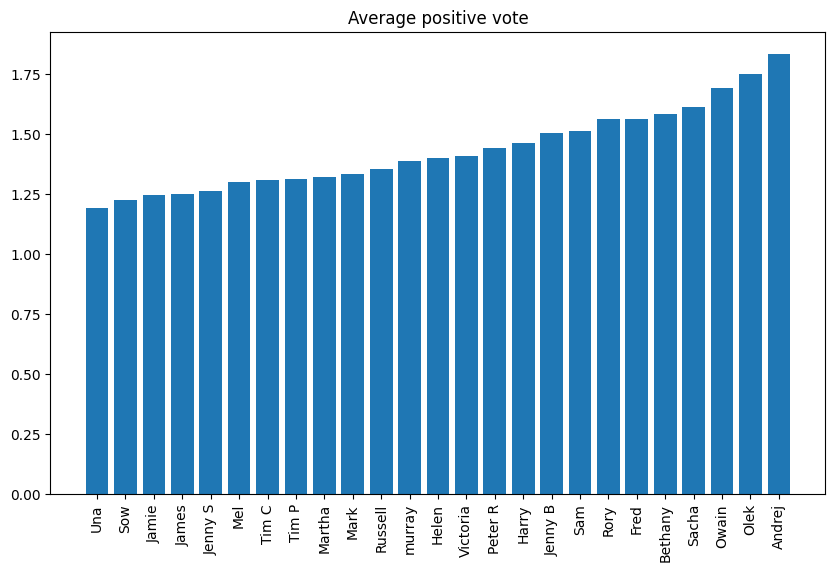

In [89]:
x = arr.reshape(-1, len(winning_order))
x[x <= 0.0] = np.nan
a = np.nanmean(x, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Average positive vote")

ax.bar(np.arange(len(winning_order)), a[np.argsort(a)])
ax.set_xticks(np.arange(len(winning_order)), labels=[winning_order[i] for i in np.argsort(a)], rotation="vertical")

plt.show()

## Average song age

Plot every players average song age with respect to today (or when this notebook was run). Note that the accuracy of date on some songs is worse than others (year vs month vs day, so this isn't 100% accurate)

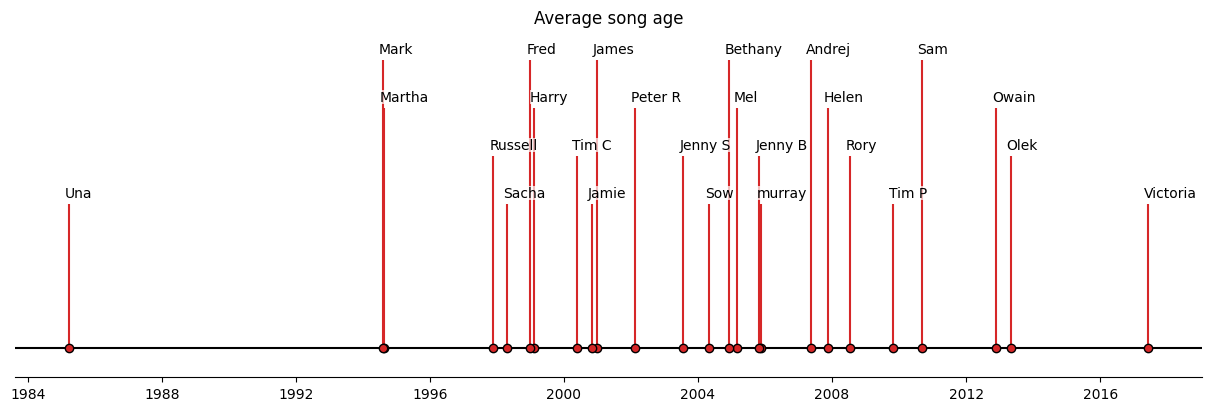

In [90]:
df["song_age_seconds"] = (datetime.now() - df["release_date"]).dt.total_seconds()
ages = df.groupby("submitter")["song_age_seconds"].mean().sort_values().map(lambda x: datetime.now() - timedelta(seconds=x))

fig, ax = plt.subplots(figsize=(12, 4), layout="constrained")
ax.set(title="Average song age")

levels = [(i % 4) / 3 + 1 for i in range(len(ages))]

# The vertical stems.
ax.vlines(ages, 0, levels,
          color=[("tab:red", 1)
                 for _ in ages])
# The baseline.
ax.axhline(0, c="black")
# The markers on the baseline
ax.plot(ages, np.zeros_like(ages), "ko", mfc="tab:red")

# Annotate the lines.
for date, level, name in zip(ages, levels, ages.index):
    ax.annotate(name, xy=(date, level),
                xytext=(-3, np.sign(level)*3), textcoords="offset points",
                verticalalignment="bottom" if level > 0 else "top",
                bbox=dict(boxstyle='square', pad=0, lw=0, fc=(1, 1, 1, 0.7)))

ax.yaxis.set(major_locator=mdates.YearLocator(),
             major_formatter=mdates.DateFormatter("%Y"))

# Remove the y-axis and some spines.
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

In [91]:
oldest = df.groupby("submitter")["song_age_seconds"].max().apply(lambda x: datetime.now() - timedelta(seconds=x)).sort_values()
youngest = df.groupby("submitter")["song_age_seconds"].min().apply(lambda x: datetime.now() - timedelta(seconds=x)).sort_values()

oldest_oldest = df.iloc[df[df["submitter"] == oldest.index[0]]["song_age_seconds"].idxmax()][["submitter", "release_date", "song_name"]]
youngest_oldest = df.iloc[df[df["submitter"] == oldest.index[-1]]["song_age_seconds"].idxmax()][["submitter", "release_date", "song_name"]]
youngest_youngest = df.iloc[df[df["submitter"] == youngest.index[-1]]["song_age_seconds"].idxmin()][["submitter", "release_date", "song_name"]]
oldest_youngest = df.iloc[df[df["submitter"] == youngest.index[0]]["song_age_seconds"].idxmin()][["submitter", "release_date", "song_name"]]

print(oldest_youngest.to_list())


['Una', Timestamp('2007-12-28 00:00:00'), 'Here Comes the Hotstepper']


In [92]:
# does song age correlate with overall position

np.corrcoef(np.c_[ages.reindex(winning_order).argsort(), np.arange(len(ages))].T)

array([[1.        , 0.42461538],
       [0.42461538, 1.        ]])

### Mean song length

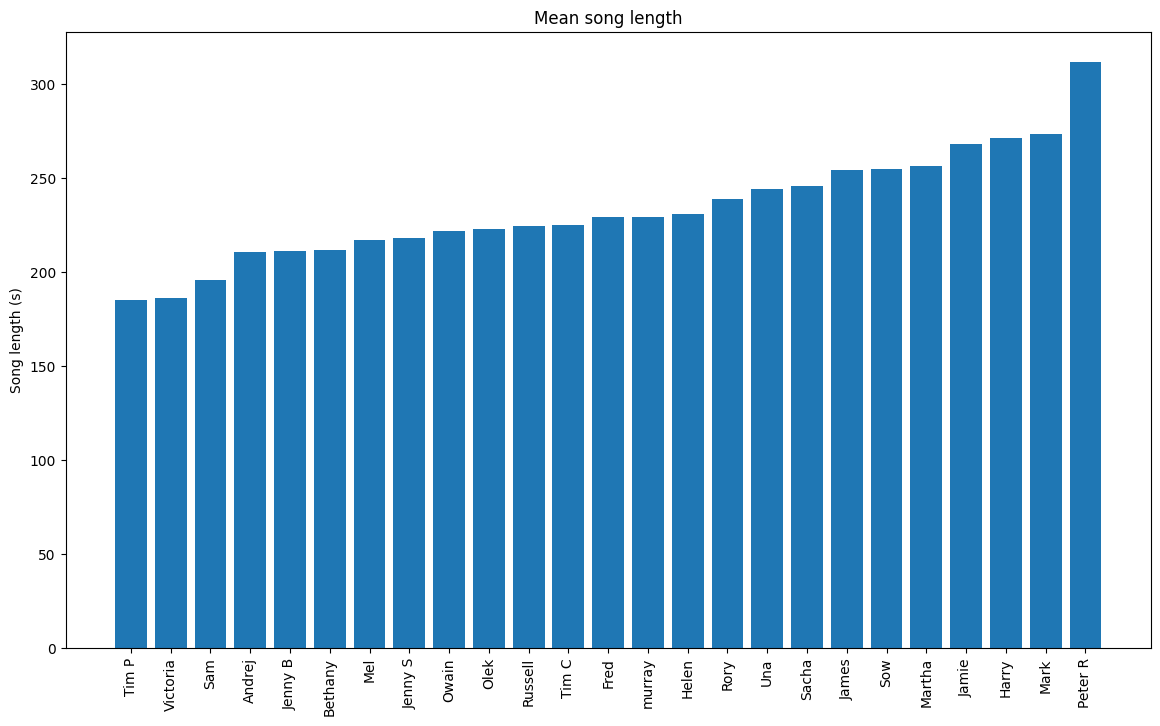

In [93]:
lengths = df.groupby("submitter")["duration_s"].mean().sort_values()

fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(np.arange(len(lengths)), lengths)
ax.set_xticks(np.arange(len(winning_order)), lengths.index, rotation='vertical')
ax.set_title("Mean song length")
ax.set_ylabel("Song length (s)")
plt.show()

In [94]:
# Correlation between mean song length and overall league rank
np.corrcoef(lengths.reindex(winning_order).rank(), np.arange(1, len(winning_order)+1))


array([[ 1.        , -0.10769231],
       [-0.10769231,  1.        ]])

### Longest and shortest songs

In [95]:
df.sort_values("duration_s", ascending=False)[["submitter", "song_name", "duration_s"]].iloc[:10]

,submitter,song_name,duration_s
162,Russell,Blue Room,1053.813
582,Jamie,Mogwai Fear Satan,979.560
241,Harry,"The Curtain - Live From Dordrecht, Het Energie...",909.106
254,Harry,Zombie,745.653
418,Peter R,"Polovtsian Dances From ""Prince Igor""",690.306
483,Rory,Black No. 1 (Little Miss Scare -All),675.653
409,Peter R,"Ghandi, Dalai Lama, Your Lord & Savior J.C. / ...",615.028
164,James,Never Gonna Reach Me - Hot Toddy Remix,580.363
555,Mark,I Love You... I'll Kill You,532.560
715,Peter R,Movement 6,530.894


In [96]:
df.sort_values("duration_s", ascending=True)[["submitter", "song_name", "duration_s"]].iloc[:10]

,submitter,song_name,duration_s
66,Tim C,Short Attention Span,8.888
72,Rory,Girl Fight,15.472
613,Sacha,I Am a Banana,39.026
301,Tim P,Theme from Strictly Come Dancing,42.000
556,Tim P,Swiper No Swiping!,46.106
425,Tim P,Mission: Impossible Theme,51.800
166,Victoria,Baby Park,55.500
427,James,The Best A Man Can Get (Gillette),60.000
607,Russell,Porcupine or Pineapple,64.825
632,Russell,Come On!,68.133


## Rankings if only downvotes/upvotes counted

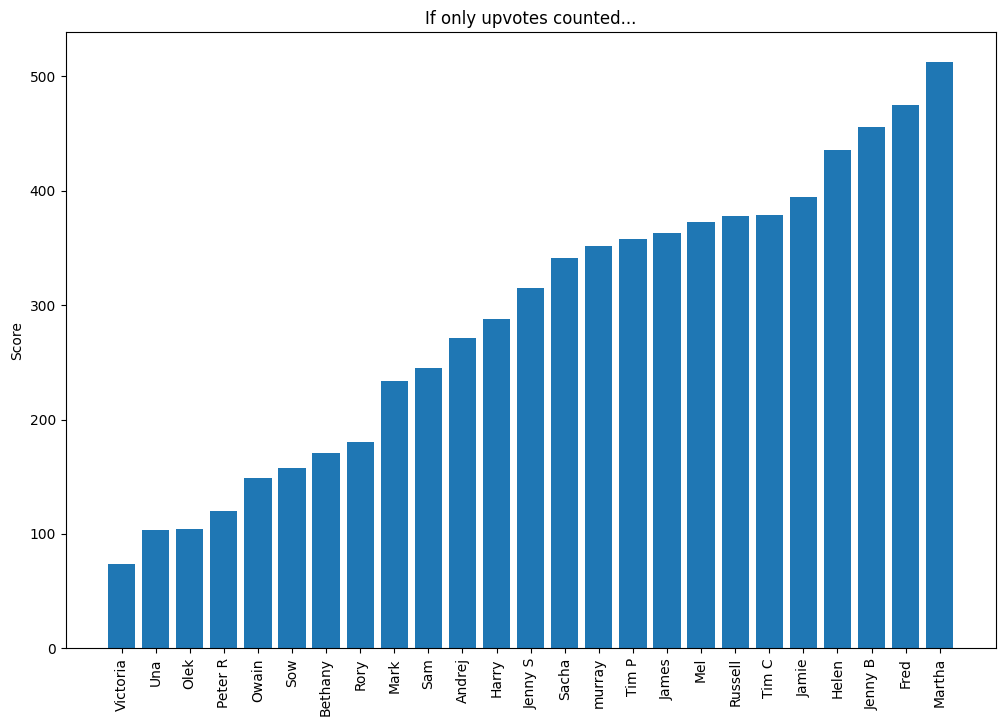

In [97]:
positive_votes = np.where(arr > 0, arr, 0)

positive_scores = np.sum(positive_votes, axis=(0, 2))

order = np.argsort(positive_scores)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(len(winning_order)), np.sort(positive_scores))
ax.set_xticks(range(len(winning_order)), [winning_order[i] for i in order], rotation="vertical")
ax.set_ylabel("Score")
ax.set_title("If only upvotes counted...")

plt.show()

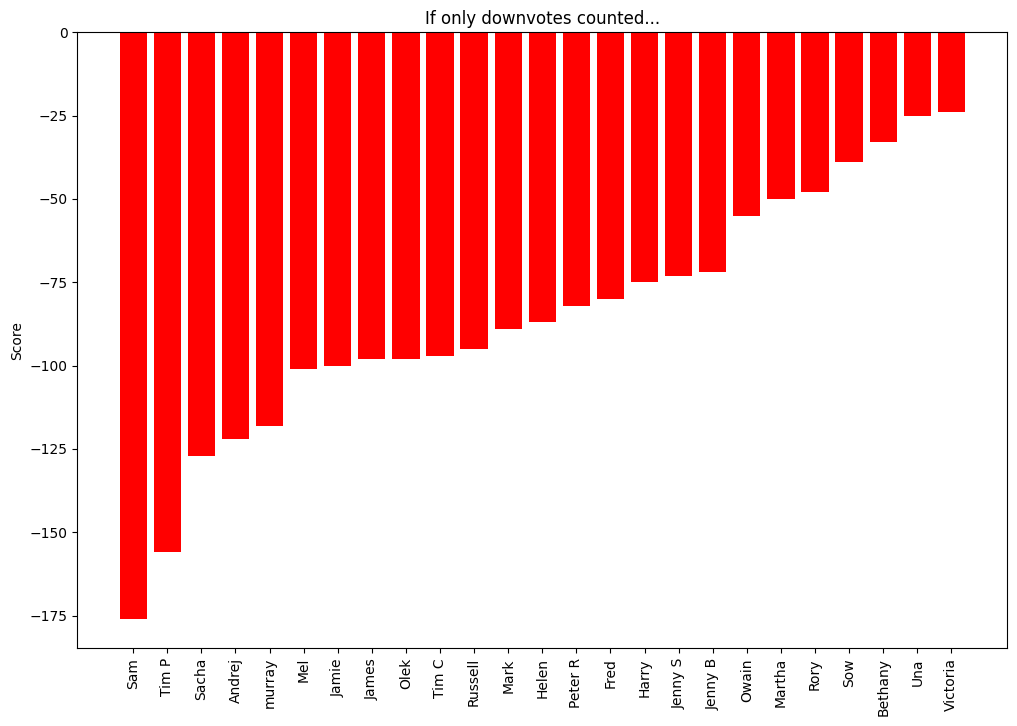

In [98]:
negative_votes = np.where(arr < 0, arr, 0)

negative_scores = np.sum(negative_votes, axis=(0, 2))

order = np.argsort(negative_scores)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(len(winning_order)), np.sort(negative_scores), color="red")
ax.set_xticks(range(len(winning_order)), [winning_order[i] for i in order], rotation="vertical")
ax.set_ylabel("Score")
ax.set_title("If only downvotes counted...")

plt.show()

## Controversy score

The controversy score aims to find the most controversial songs, those with the highest numbers of upvotes and downvotes leaving a score near 0

The controversy score $C$ is calculated using the following formula:


$C = \sqrt{\frac{1}{N_{\neq 0}} \sum_{i=1}^{N_{\neq 0}} (v_i - \mu)^2} \times \left( \sum_{i=1}^{n} v_i \text{ where } v_i > 0 \ - \ \alpha \sum_{i=1}^{n} v_i \text{ where } v_i < 0 \right)$


Where:
- $v_i$ are the individual votes.
- $\mu$ is the mean of the non-zero votes.
- $N_{\neq 0}$ is the number of non-zero votes.
- $\alpha$ is the ratio of positive to negative votes ($\frac{10}{3}$ in this league)
- The first part of the equation represents the standard deviation of the non-zero votes.
- The second part represents a modified range that accounts for positive and scaled negative votes.


/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


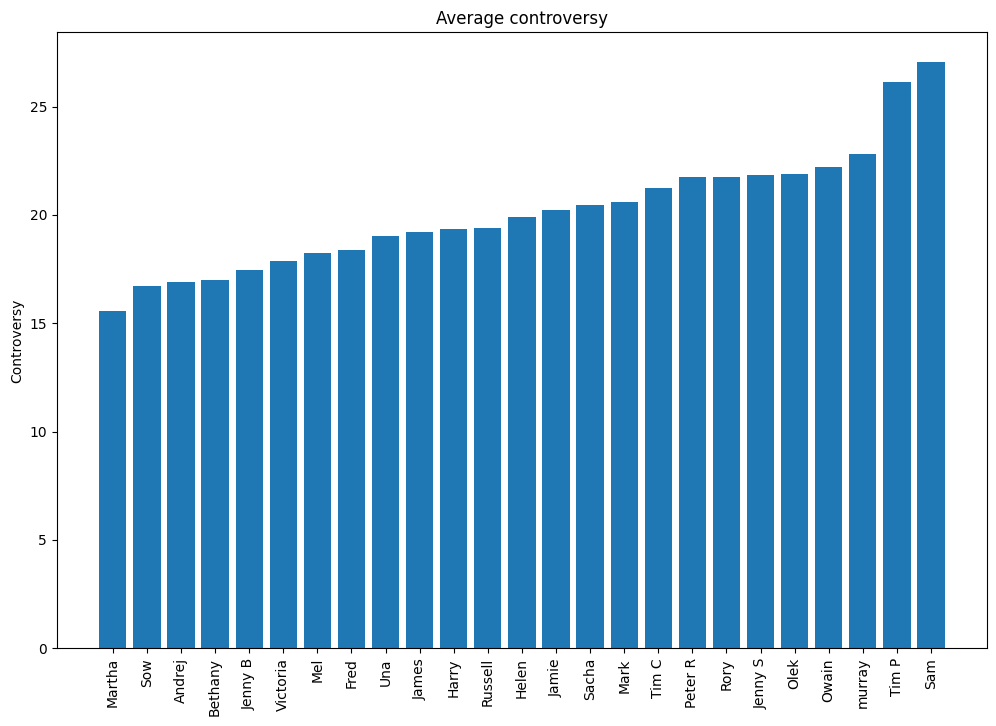

In [99]:
def controversy(vals):
    std = np.std([i for i in vals if i])
    range = sum(i for i in vals if i > 0.0) - (sum(i for i in vals if i < 0.0) * 10/3)
    return std * range

df["controversy"] = df[names].fillna(0).apply(controversy, axis=1)
df.sort_values("controversy", ascending=False)[["submitter", "song_name", "round", "controversy"]].iloc[:10]

fig, ax = plt.subplots(figsize=(12, 8))

vals = df.groupby("submitter")["controversy"].mean().sort_values()

ax.bar(np.arange(len(vals)), vals)
ax.set_xticks(range(len(vals)), vals.index, rotation="vertical")
ax.set_ylabel("Controversy")
ax.set_title("Average controversy")

plt.show()

In [100]:
df.sort_values("controversy", ascending=False)[["controversy", "submitter", "round", "song_name"]].iloc[:10]

,controversy,submitter,round,song_name
576,116.833214,Sam,Colours 🎨,"Love Me Like You Do (From ""50 Shades of Grey"")..."
205,87.689741,Sam,One hit wonder 🌟,Imagine - Remastered 2010
161,87.062132,Sam,Songs to code to 👩‍💻,Screaming Man - Sound Effect
30,83.486339,Fred,Yesteryear 📅,Padam Padam
58,81.649658,Jamie,120 seconds to go ⏱,Golden Slumbers - Remastered 2009
537,71.527709,murray,Musicals 🎭,Hard Candy Christmas
56,71.154154,James,Cover🎪,Bohemian Rhapsody
15,71.045525,Sam,Eurovision💶👀,Bono's a Fucking Cunt
241,69.565516,Harry,Best live version 🎤,"The Curtain - Live From Dordrecht, Het Energie..."
582,64.466759,Jamie,🎸 Best instrumental,Mogwai Fear Satan


In [101]:
print("Number of explicit songs submitted")
df.groupby("submitter")["explicit"].sum().sort_values(ascending=False)

Number of explicit songs submitted


submitter
Mel         10
Sacha        9
murray       8
Tim P        7
Sam          6
Jenny B      6
Tim C        6
Russell      6
Bethany      6
Fred         5
Jamie        4
Helen        4
James        4
Rory         4
Martha       3
Jenny S      2
Owain        2
Olek         2
Andrej       1
Victoria     1
Sow          1
Harry        0
Mark         0
Peter R      0
Una          0
Name: explicit, dtype: int64

In [102]:
# Every explicit song
df[df["explicit"]][["submitter", "round", "song_name", "artist_names"]]

,submitter,round,song_name,artist_names
5,Fred,Eurovision💶👀,Dancing Lasha Tumbai,[Verka Serduchka]
15,Sam,Eurovision💶👀,Bono's a Fucking Cunt,[Pizzatramp]
19,Jamie,Yesteryear 📅,Nothing Matters,[The Last Dinner Party]
23,Rory,Yesteryear 📅,Punk's Dead,[SOFT PLAY]
27,Mel,Yesteryear 📅,Who The Fuck?,[Wheeler Walker Jr.]
...,...,...,...,...
702,Mel,🤝 Most surprising collaboration,Don't Hurt Yourself (feat. Jack White),"[Beyoncé, Jack White]"
709,Tim P,🤝 Most surprising collaboration,Sorry Not Sorry (with Slash) - Rock Version,"[Demi Lovato, Slash]"
710,murray,🤝 Most surprising collaboration,One and Only,"[Timbaland, Fall Out Boy]"
718,murray,🎯 Darts walk on song,"Ooh Wee (feat. Ghostface Killah, Nate Dogg, Tr...","[Mark Ronson, Ghostface Killah, Nate Dogg, Tri..."


## League Rankings over time

/tmp/ipykernel_60122/2741832657.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab20", len(submitters))  # or "tab10", "Set1", etc.


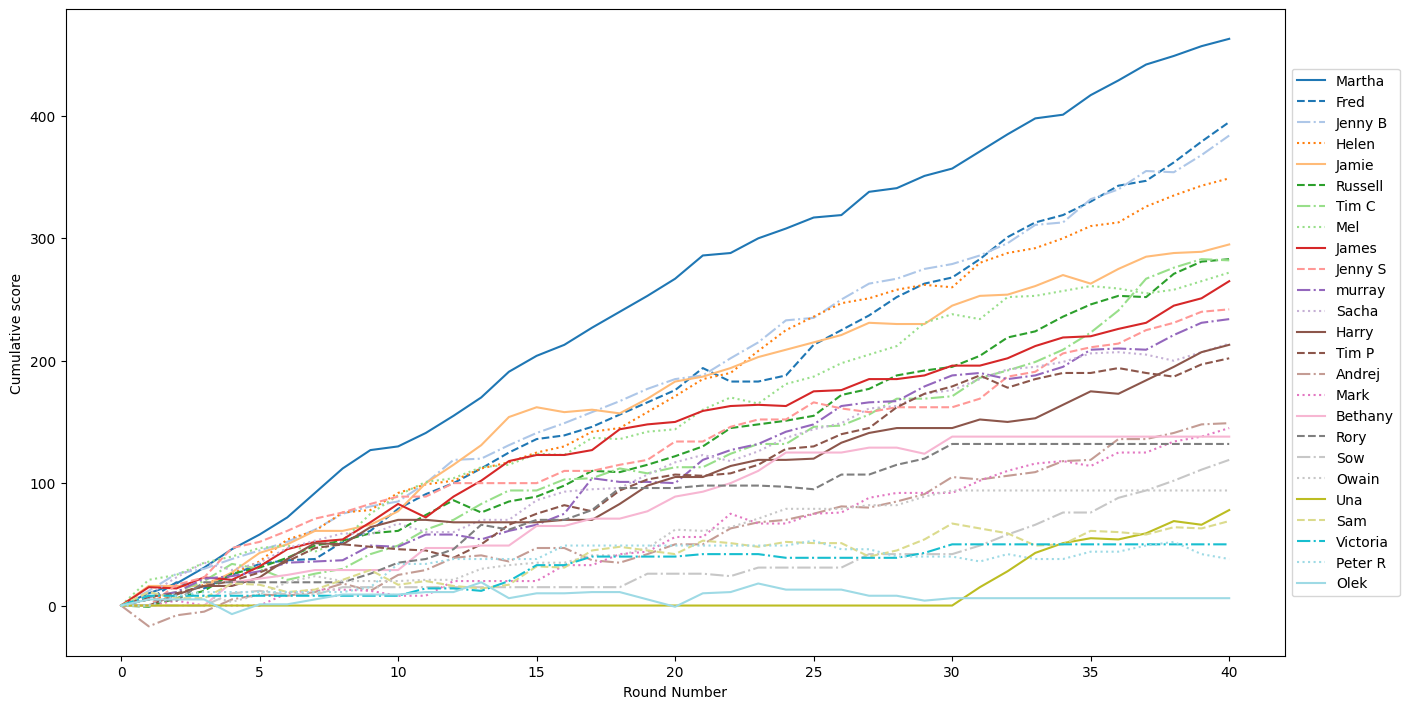

In [111]:
fig, ax = plt.subplots(figsize=(14, 7))

# Get a list of unique submitters
submitters = df["submitter"].unique()
colors = cm.get_cmap("tab20", len(submitters))  # or "tab10", "Set1", etc.
linestyles = ['-', '--', '-.', ':']

scores: dict[list[int]] = {name: [0] for name in winning_order}
df = df.sort_values(["league", "round_number"])
for round, round_df in df.groupby("round"):
    round_scores = round_df.groupby("submitter")["round_score"].first().to_dict()
    for name in winning_order:
        scores[name].append(round_scores.get(name, 0))

for i, (name, round_scores) in enumerate(scores.items()):
    color = colors(i)
    linestyle = linestyles[i % len(linestyles)]
    ax.plot(list(np.cumsum(round_scores)), label=name, color=color, linestyle=linestyle)

# Move the legend outside the plot to the right
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()  # Adjust layout to make room for the legend

# plt.xticks(range(df["round_number"].max() + 1))
# plt.vlines(range(df["round_number"].max() + 1),
#            min(map(lambda x: np.cumsum(x)[-1], scores.values())),
#            max(map(lambda x: np.cumsum(x)[-1], scores.values())),
#            'k', linestyles='--', alpha=0.2)

plt.xlabel("Round Number")
plt.ylabel("Cumulative score")

plt.show()

## Points Received Distribution

The box extends from the first quartile (Q1) to the third quartile (Q3) of the data, with a line at the median. The whiskers extend from the box to the farthest data point lying within 1.5x the inter-quartile range (IQR) from the box. Flier points are those past the end of the whiskers

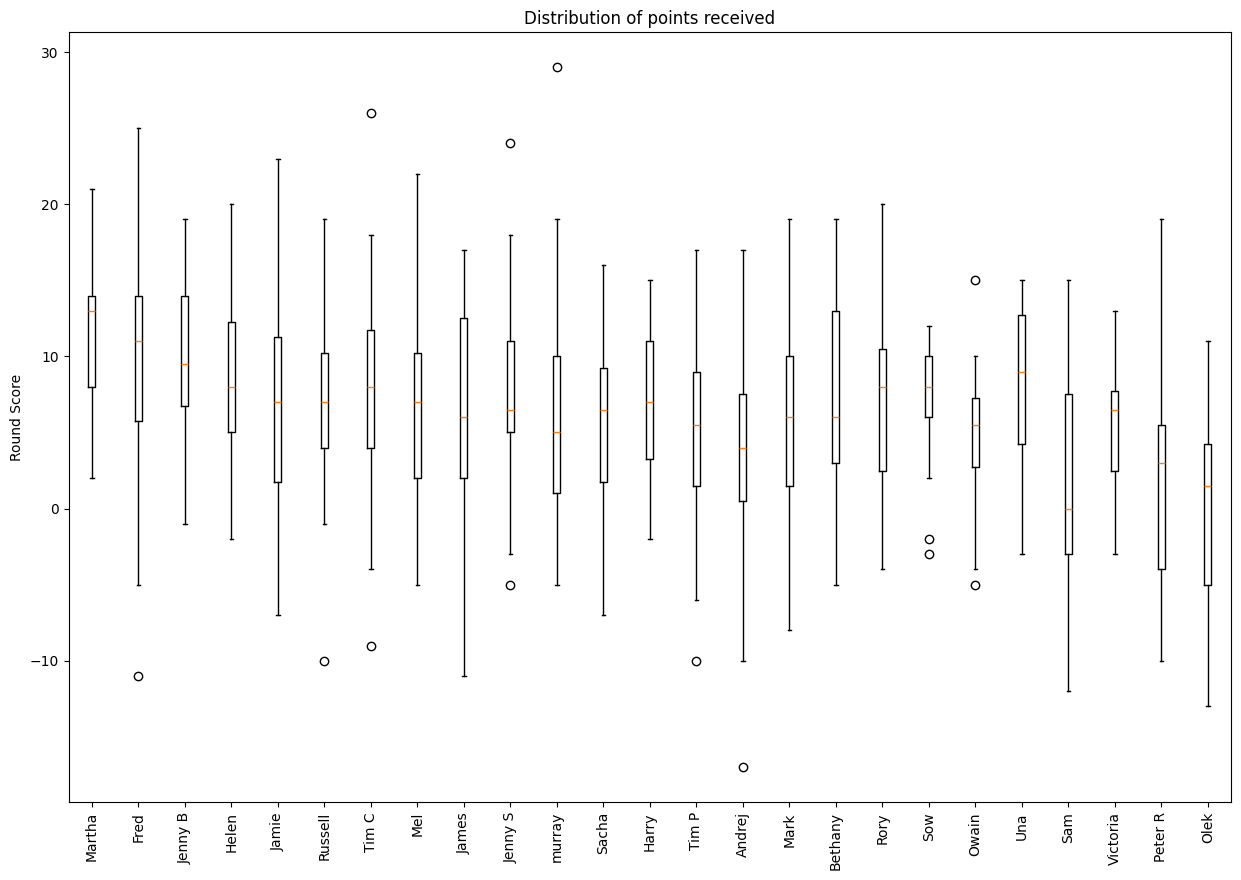

In [104]:
fig, ax = plt.subplots(figsize=(15,10))

for i, submitter in enumerate(winning_order):
    ax.boxplot(df[df["submitter"] == submitter]["round_score"], positions=[i])

plt.title("Distribution of points received")
plt.ylabel("Round Score")
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')


plt.show()

### One hit wonders

Who had the biggest outlier from their usual scoring

In [105]:
means = df.groupby("submitter")["round_score"].mean().to_dict()
stds = df.groupby("submitter")["round_score"].std().to_dict()
df["std_distance"] = (df["round_score"] - df["submitter"].map(means)) / df["submitter"].map(stds)
df.loc[df.groupby("submitter")["std_distance"].idxmax()].sort_values("std_distance", ascending=False)[["submitter", "song_name", "round_score", "std_distance"]]

,submitter,song_name,round_score,std_distance
168,murray,Mundian to Bach Ke,29.0,3.466738
617,Tim C,Ready or Not,26.0,2.771032
227,Jenny S,The Man Who Sold The World - Live,24.0,2.625712
558,Peter R,yellow is the color of her eyes,19.0,2.450904
465,Fred,I Put A Spell On You,25.0,2.268069
637,Helen,Ice Ice Baby,20.0,2.265510
113,Jamie,Lose Yourself,23.0,2.262918
188,Owain,Somebody That I Used To Know,15.0,2.185017
539,Mel,Psycho Killer,22.0,2.157140
330,Mark,We Care a Lot,19.0,2.136324


### One hit blunders

In [106]:
df["std_distance"] = (df["submitter"].map(means) - df["round_score"]) / df["submitter"].map(stds)
df.loc[df.groupby("submitter")["std_distance"].idxmax()].sort_values("std_distance", ascending=False)[["submitter", "song_name", "round_score", "std_distance"]]

,submitter,song_name,round_score,std_distance
75,Andrej,Baby Shark,-17.0,3.152278
350,Fred,Funny Little Man,-11.0,3.130310
18,Russell,Congratulations,-10.0,3.054438
56,James,Bohemian Rhapsody,-11.0,2.789533
391,Tim C,Paranoid (2012 Remaster),-9.0,2.449184
774,Tim P,Butt Cheeks Butt Cheeks Butt Cheeks!,-10.0,2.401340
389,Sow,My Love (feat. T.I.),-3.0,2.332847
55,Sacha,Painkiller,-7.0,2.185733
37,Helen,Even It Out,-2.0,2.154997
518,Jenny S,BIBI Vengeance,-5.0,2.153304


## Essay Writers

Who writes the most text, either in their song info, or in the comments.

In [107]:
word_counts = (
    comment_df.groupby("submitter")["submitter_comment"]
    .apply(lambda comments: comments.str.split().str.len().sum())
).sort_values(ascending=False)

word_counts

submitter
Harry       493
Mark        255
Jenny B     219
Tim C       212
Russell     202
James       162
Sow         143
Fred        143
Helen       141
Peter R     135
Jenny S     128
Tim P       106
Andrej       97
murray       91
Una          85
Sam          77
Jamie        66
Mel          66
Sacha        49
Martha       36
Olek         34
Bethany      32
Owain        25
Rory         11
Victoria      9
Name: submitter_comment, dtype: int64

In [108]:
comment_counts = comment_df[winning_order].apply(lambda comments: comments.str.split().str.len().sum(), axis=0).sort_values(ascending=False)
comment_counts

Russell     1160.0
Jenny B     1086.0
Fred         758.0
Harry        711.0
Mark         699.0
Rory         384.0
Helen        287.0
Una          251.0
Mel          247.0
murray       202.0
Jenny S      198.0
Sacha        171.0
Tim C        168.0
Jamie        151.0
Tim P        110.0
Owain         95.0
Peter R       79.0
James         78.0
Olek          61.0
Andrej        52.0
Martha        47.0
Victoria      20.0
Bethany       12.0
Sam           12.0
Sow           10.0
dtype: float64

## Mel's Vendetta

How many times has Mel tried and failed to downvote Fred

In [119]:
for submitter, song, comment in comment_df[comment_df["Mel"].str.lower().str.contains("fred")][["submitter", "song_name", "Mel"]].values:
    print(f"{submitter:<15s} {song:<50s} {comment}")

Fred            Funny Little Man                                   Downvoting in the hope it’s Fred, sorry for the stray bullet if it’s not 
Peter R         Girl, so confusing featuring lorde                 charli xcx is hardly a vocalist. also i hope this is fred
Helen           Blue Monday                                        Downvoting bc it might be Fred 
Harry           Crystal Blue Persuasion                            This actually might be Fred, but it’s a risk I’ll take 
Russell         Yellow Submarine                                   Also downvoting bc it might be Fred
murray          Coat of Many Colors                                Saved from downvote bc I’m trying to get Fred 
Una             Hanging On The Telephone                           I liked this but I think it might be Fred 
Harry           Jah Victory                                        Might be Fred 
Peter R         A Day In The Life - Remastered 2009                I had to stop what I was doing to do

In [129]:
((df["Mel"] < 0) & (df["submitter"] == "Fred")).sum() / (df["Mel"] < 0).sum()

np.float64(0.039603960396039604)